# Solving linear systems of equations using the HHL algorithm 

In this tutorial, we introduce the HHL algorithm, derive the circuit, and implement it using Qiskit. We demonstrate how to run this algorithm on a simulator, as well as on a four-qubit device.

## Contents
1. [Introduction](#introduction)
2. [The HHL algorithm](#hhlalg)
    1. [Conditions] (#conditions)
    2. [Significance in Machine Learning] (#ml)
    2. [Some mathematical background](#mathbackground)
    3. [Description of the HHL](#hhldescription)
    4. [Quantum Phase Estimation (QPE) within HHL](#qpe)
    5. [Non-exact QPE](#qpe2)
3. [Example 1: 4-qubit HHL](#example1)
4. [Qiskit Implementation](#implementation)
    1. [Running HHL on a simulator: general method](#implementationsim)
    2. [Running HHL on a real quantum device: optimised example](#implementationdev)
5. [Problems](#problems)
6. [References](#references)

## 1. Introduction <a id='introduction'></a>

Linear system of equations are ubiquitous throughout science and engineering, and, in every sector of research, manipulating matrices efficiently has become a massive area of interest. They arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation. 

Most classical methods for matrix manipulation do work in polynomial time, (unlike the classical solutions to the Deutsch-Jozsa and search problems that we've seen earlier). Unfortunately, as data analysis becomes more and more powerful, the size of these matrices can make even polynomial time too long. 

Developed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd, HHL is a quantum algorithm that approximates a function of the solution vector of a linear system of equations, with running time complexity of $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$<sup>[1](#hhl)</sup>. This time reduction has significant implications for the speedup of many machine learning algorithms on quantum computers.

The problem can be defined as, given a matrix $A\in\mathbb{C}^{N\times N}$ and a vector $\vec{b}\in\mathbb{C}^{N}$, find $\vec{x}\in\mathbb{C}^{N}$ satisfying $A\vec{x}=\vec{b}$

For example, take $N=2$, 

$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\\ x_{2}\end{pmatrix}\quad \text{and} \quad \vec{b}=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

Hence, the problem can be written as find $x_{1}, x_{2}\in\mathbb{C}$ such that
$$\begin{cases}x_{1} - \frac{x_{2}}{3} = 1 \\ -\frac{x_{1}}{3} + x_{2} = 0\end{cases} $$

## 2. The HHL algorithm<a id='hhlalg'></a>

### A. Conditions <a id='conditions'></a>
The given Linear system has to have a low condition number ${\displaystyle \kappa },$ and the Matrix $A$ must be $s$-sparse. This means $A$ must have at most $s$ non-zero entries per row or column. Solving an $s$-sparse system of size $N$ with a classical computer requires $\mathcal{ O }(Ns\kappa\log(1/\epsilon))$ running time using the conjugate gradient method <sup>[2](#conjgrad)</sup>. Here, $\epsilon$ deonotes the accuracy of the approximation.
 
It is assumed that the user of the algorithm is interested in the result of a scalar measurement on the solution vector, instead of the values of the solution vector itself. So, it assumes that the user is not interested in the values of ${\displaystyle {\overrightarrow {x}}}$ itself, but rather the result of applying some operator ${\displaystyle M}$ onto x, ${\displaystyle \langle x|M|x\rangle }$. Hence, while the classical algorithm returns the full solution, the HHL can only approximate functions of the solution vector.

Also, Matrix ${\displaystyle A}$ should be Hermitian so that it can be converted into a unitary operator, under the assumptions of efficient oracles for loading the data, Hamiltonian simulation and computing a function of the solution. 

### B. Significance in Machine Learning<a id='ml'></a>
The time required for a least-squares fit (a continuous function to model a set of discrete points) has been found to become very large as the amount of discrete points increases. However, a research group has developed a quantum algorithm that incorporates HHL to solve many cases of least-squares efficiently, eliminating the need for the previously best higher-complexity algorithm <sup>[3](#ml)</sup>.

Of course, HHL is thought to be massively useful in machine learning, where classical algorithms are limited by a polynomial dependence on the volume of data and dimensions of the space. One specific use for HHL in machine learning is in an optimized linear or non-linear binary classifier, or support vector machine. Research has shown that a quantum support vector machine can be used for big data classification and achieve an exponential speedup over classical computers <sup>[4](#data)</sup> . A quantum algorithm has also been developed for Bayesian training of deep neural networks, with an exponential speedup over classical training due to the use of HHL.


### C. Some mathematical background<a id='mathbackground'></a>
The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language. By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$. Usually the mapping used is such that $i^{th}$ component of $\vec{b}$ (resp. $\vec{x}$) corresponds to the amplitude of the $i^{th}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$). From now on, we will focus on the rescaled problem

$$ A|x\rangle=|b\rangle$$

Since $A$ is Hermitian, it has a spectral decomposition
$$
A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\quad \lambda_{j}\in\mathbb{ R }
$$
where $|u_{j}\rangle$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$.  It can be written as a the sum of the outer products of its eigenvectors, scaled by its eigenvalues. Therefore, we can write the inverse of A as
$$A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}|
$$
Since $A$ is invertible and Hermitian, it must have an orthogonal basis of eigenvectors, and thus we can write $b$ in the eigenbasis of $A$ as
$$
|b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j}\rangle,\quad b_{j}\in\mathbb{ C }
$$
It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state
$$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle
$$
Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

### D. Description of the HHL algorithm <a id='hhldescription'></a>

The algorithm uses three quantum registers, all of them set to $|0\rangle $ at the beginning of the algorithm. One register, which we will denote with the subindex $n_{l}$, is used to store a binary representation of the eigenvalues of $A$. A second register, denoted by $n_{b}$, contains the vector solution, and from now on $N=2^{n_{b}}$. There is an extra register, for the auxiliary qubits. These are qubits used as intermediate steps in the individual computations but will be ignored in the following description since they are set to $|0\rangle $ at the beginning of each computation and restored back to the $|0\rangle $ state at the end of the individual operation.

The following is an outline of the HHL algorithm with a high-level drawing of the corresponding circuit. For simplicity all computations are assumed to be exact in the ensuing description, and a more detailed explanation of the non-exact case is given in Section [2.D.](#qpe2).

<img src="images/hhlcircuit.png" width = "75%" height = "75%">

1.  Load the data $|b\rangle\in\mathbb{ C }^{N}$. That is, perform the transformation
    $$ |0\rangle _{n_{b}} \mapsto |b\rangle _{n_{b}} $$
2. Apply Quantum Phase Estimation (QPE) with
	$$
	U = e ^ { i A t } := \sum _{j=0}^{N-1}e ^ { i \lambda _ { j } t } |u_{j}\rangle\langle u_{j}|
	$$
	The quantum state of the register expressed in the eigenbasis of $A$ is now
	$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
	$$
    where $|\lambda _ {j }\rangle_{n_{l}}$ is the $n_{l}$-bit binary representation of $\lambda _ {j }$.
    
3. Add an auxiliary qubit and apply a rotation conditioned on $|\lambda_{ j }\rangle$,
	$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac { C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
	$$
	where $C$ is a normalisation constant, and, as expressed in the current form above, should be less than the smallest eigenvalue $\lambda_{min}$ in magnitude, i.e., $|C| < \lambda_{min}$.
    
4. Apply QPE$^{\dagger}$. Ignoring possible errors from QPE, this results in
	$$
	\sum_{j=0}^{N-1} b _ { j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
	$$
    
5. Measure the auxiliary qubit in the computational basis. If the outcome is $1$, the register is in the post-measurement state
	$$
	\left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum _{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
	$$
	which up to a normalisation factor corresponds to the solution.

6. Apply an observable $M$ to calculate $F(x):=\langle x|M|x\rangle$.

### E. Quantum Phase Estimation (QPE) within HHL <a id='qpe'></a>

Quantum Phase Estimation is described in more detail in Chapter 3. However, since this quantum procedure is at the core of the HHL algorithm, we recall here the definition. Roughly speaking, it is a quantum algorithm which, given a unitary $U$ with eigenvector $|\psi\rangle_{m}$ and eigenvalue $e^{2\pi i\theta}$, finds $\theta$. We can formally define this as follows.

**Definition:** Let $U\in\mathbb{ C }^{2^{m}\times 2^{m}}$ be unitary and let $|\psi\rangle_{m}\in\mathbb{ C }^{2^{m}}$ be one of its eigenvectors with respective eigenvalue $e^{2\pi i\theta}$. The **Quantum Phase Estimation** algorithm, abbreviated **QPE**, takes as inputs the unitary gate for $U$ and the state $|0\rangle_{n}|\psi\rangle_{m}$ and returns the state $|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}$. Here $\tilde{\theta}$ denotes a binary approximation to $2^{n}\theta$ and the $n$ subscript denotes it has been truncated to $n$ digits.	
$$
\operatorname { QPE } ( U , |0\rangle_{n}|\psi\rangle_{m} ) = |\tilde{\theta}\rangle_{n}|\psi\rangle_{m}
$$

For the HHL we will use QPE with $U = e ^ { i A t }$, where $A$ is the matrix associated to the system we want to solve. In this case, 
$$
e ^ { i A t } = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j}|
$$
Then, for the eigenvector $|u_{j}\rangle_{n_{b}}$, which has eigenvalue $e ^ { i \lambda _ { j } t }$, QPE will output $|\tilde{\lambda }_ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$. Where $\tilde{\lambda }_ { j }$ represents an $n_{l}$-bit binary approximation to $2^{n_l}\frac{\lambda_ { j }t}{2\pi}$. Therefore, if each $\lambda_{j}$ can be exactly represented with $n_{l}$ bits,
$$
\operatorname { QPE } ( e ^ { i A t } , \sum_{j=0}^{N-1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} ) = \sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$

### F. Non-exact QPE <a id='qpe2'></a>

In reality, the quantum state of the register after applying QPE to the initial state is
$$
\sum _ { j=0 }^{N-1} b _ { j } \left( \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } |l\rangle_{n_{l}} \right)|u_{j}\rangle_{n_{b}}
$$
where
$$
\alpha _ { l | j } = \frac { 1 } { 2 ^ { n_{l} } } \sum _ { k = 0 } ^ { 2^{n_{l}}- 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l } { 2 ^ { n_{l} } } \right) } \right) ^ { k }
$$

Denote by $\tilde{\lambda_{j}}$ the best $n_{l}$-bit approximation to $\lambda_{j}$, $1\leq j\leq N$. Then we can relabel the $n_{l}$-register so that $\alpha _ { l | j }$ denotes the amplitude of $|l + \tilde { \lambda } _ { j } \rangle_{n_{l}}$. So now,
$$
\alpha _ { l | j } : = \frac { 1 } { 2 ^ { n_{l}} } \sum _ { k = 0 } ^ { 2 ^ { n_{l} } - 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } } \right) } \right) ^ { k }
$$
If each $\frac { \lambda _ { j } t } { 2 \pi }$ can be represented exactly with $n_{l}$ binary bits, then $\frac { \lambda _ { j } t } { 2 \pi }=\frac { \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ $\forall j$. Therefore in this case $\forall j$, $1\leq j \leq N$, it holds that $\alpha _ { 0 | j } = 1$ and $\alpha _ { l | j } = 0 \quad \forall l \neq 0$. Only in this case we can write that the state of the register after QPE is 
$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
$$
Otherwise, $|\alpha _ { l | j }|$ is large if and only if $\frac { \lambda _ { j } t } { 2 \pi } \approx \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ and the state of the register is
$$
\sum _ { j=0 }^{N-1}  \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } b _ { j }|l\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
$$

## 3. Example: 4-qubit HHL<a id='example1'></a>

Let's take the small example from the introduction to illustrate the algorithm. That is,
$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

We will use $n_{b}=1$ qubit to represent $|b\rangle$, and later the solution $|x\rangle$, $n_{l}=2$ qubits to store the binary representation of the eigenvalues and $1$ auxiliary qubit to store whether the conditioned rotation, hence the algorithm, was successful.

For the purpose of illustrating the algorithm, we will cheat a bit and calculate the eigenvalues of $A$ to be able to choose $t$ to obtain an exact binary representation of the rescaled eigenvalues in the $n_{l}$-register. However, keep in mind that for the HHL algorithm implementation one does not need previous knowledge of the eigenvalues. Having said that, a short calculation will give
$$\lambda_{1} = 2/3\quad\text{and}\quad\lambda_{2}=4/3$$

Recall from the previous section that the QPE will output an $n_{l}$-bit ($2$-bit in this case) binary approximation to $\frac{\lambda_ { j }t}{2\pi}$. Therefore, if we set 
$$t=2\pi\cdot \frac{3}{8}$$
the QPE will give a $2$-bit binary approximation to
$$\frac{\lambda_ { 1 }t}{2\pi} = 1/4\quad\text{and}\quad\frac{\lambda_ { 2 }t}{2\pi}=1/2$$
which is, respectively,
$$|01\rangle_{n_{l}}\quad\text{and}\quad|10\rangle_{n_{l}}$$

The eigenvectors are, respectively,
$$|u_{1}\rangle=\frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ -1\end{pmatrix}\quad\text{and}\quad|u_{2}\rangle=\frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ 1\end{pmatrix}$$
Again, keep in mind that one does not need to compute the eigenvectors for the HHL implementation. In fact, a general Hermitian matrix $A$ of dimension $N$ can have up to $N$ different eigenvalues, therefore calculating them would take $\mathcal{O}(N)$ time and the quantum advantage would be lost.

We can then write $|b\rangle$ in the eigenbasis of $A$ as
$$|b\rangle _{n_{b}}=\sum_{j=1}^{2}\frac{1}{\sqrt{2}}|u_{j}\rangle _{n_{b}}$$

Now we are ready to go through the different steps of the HHL algorithm. 

1. State preparation in this example is trivial since $|b\rangle=|0\rangle$.
2. Applying QPE will yield
$$
\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle
$$
3. Conditioned rotation with $C=1/8$ that is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$. Note, the constant $C$ here needs to be chosen such that it is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$ but as large as possible so that when the auxiliary qubit is measured, the probability of it being in the state $|1>$ is large.
$$\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/4)^{2} } } |0\rangle + \frac { 1/8 } { 1/4 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/2)^{2} } } |0\rangle + \frac { 1/8 } { 1/2 } |1\rangle \right)
$$
$$
=\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
4. After applying QPE$^{\dagger}$ the quantum computer is in the state
$$
\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
5. On outcome $1$ when measuring the auxiliary qubit, the state is 
$$
\frac{\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\frac { 1 } { 2 } |1\rangle + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\frac { 1 } { 4 } |1\rangle}{\sqrt{5/32}}
$$
A quick calculation shows that
$$
\frac{\frac{1}{2\sqrt{2}}|u_{1}\rangle+ \frac{1}{4\sqrt{2}}|u_{2}\rangle}{\sqrt{5/32}} = \frac{|x\rangle}{||x||}
$$
6. Without using extra gates, we can compute the norm of $|x\rangle$: it is the probability of measuring $1$ in the auxiliary qubit from the previous step.
$$
P(|1\rangle) = \left(\frac{1}{2\sqrt{2}}\right)^{2} + \left(\frac{1}{4\sqrt{2}}\right)^{2} = \frac{5}{32} = ||x||^{2}
$$



## 4. Qiskit Implementation<a id='implementation'></a>

Now that we have analytically solved the problem from the example we are going to use it to illustrate how to run the HHL on a quantum simulator and on the real hardware. For the quantum simulator, Qiskit already provides an implementation of the HHL algorithm requiring only the matrix $A$ and $|b\rangle$ as inputs in the simplest example. Although we can give the algorithm a general Hermitian matrix and an arbitrary initial state as NumPy arrays, in these cases the quantum algorithm will not achieve an exponential speedup. This is because the default implementation is exact and therefore exponential in the number of qubits (there is no algorithm that can prepare exactly an arbitrary quantum state using polynomial resources in the number of qubits or that can perform exactly the operation $e^{iAt}$ for some general Hermitian matrix $A$ using polynomial resources in the number of qubits). If we know an efficient implementation for a particular problem, the matrix and/or the vector can be given as `QuantumCircuit` objects. Alternatively, there's already an efficient implementation for tridiagonal Toeplitz matrices and in the future there might be more.

However, at the time of writing the existing quantum computers are noisy and can only run small circuits. Therefore, in Section [4.B.](#implementationdev) we will see an optimised circuit that can be used for a class of problems to which our example belongs and mention the existing procedures to deal with noise in quantum computers.

## A. Running HHL on a simulator: general method<a id='implementationsim'></a>

The interface for all algorithms to solve the linear system problem is `LinearSolver`. The problem to be solved is only specified when the `solve()` method is called:
```python
LinearSolver(...).solve(matrix, vector)
```

The simplest implementation takes the matrix and the vector as NumPy arrays. Below we also create a `NumPyLinearSolver` (the classical algorithm) to validate our solutions.

In [1]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])
naive_hhl_solution = HHL().solve(matrix, vector)

For the classical solver we need to rescale the right hand side (i.e. `vector / np.linalg.norm(vector)`) to take into account the renormalisation that occurs once `vector` is encoded in a quantum state within HHL.

In [2]:
classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))

The `linear_solvers` package contains a folder called `matrices` intended to be a placeholder for efficient implementations of particular types of matrices. At the time of writing the only truly efficient implementation it contains (i.e. complexity scaling polynomially in the number of qubits) is the `TridiagonalToeplitz` class. Tridiagonal Toeplitz symmetric real matrices are of the following form 
$$A = \begin{pmatrix}a & b & 0 & 0\\b & a & b & 0 \\ 0 & b & a & b \\ 0 & 0 & b & a \end{pmatrix}, a,b\in\mathbb{R}$$
(note that in this setting we do not consider non symmetric matrices since the HHL algorithm assumes that the input matrix is Hermitian).

Since the matrix $A$ from our example is of this form we can create an instance of `TridiagonalToeplitz(num_qubits, a, b)` and compare the results to solving the system with an array as input.

In [3]:
from qiskit.algorithms.linear_solvers.matrices.tridiagonal_toeplitz import TridiagonalToeplitz
tridi_matrix = TridiagonalToeplitz(1, 1, -1 / 3)

tridi_solution = HHL().solve(tridi_matrix, vector)

Recall that the HHL algorithm can find a solution exponentially faster in the size of the system than their classical counterparts (i.e. logarithmic complexity instead of polynomial). However the cost for this exponential speedup is that we do not obtain the full solution vector.
Instead, we obtain a quantum state representing the vector $x$ and learning all the components of this vector would take a linear time in its dimension, diminishing any speedup obtained by the quantum algorithm.

Therefore, we can only compute functions from $x$ (the so called observables) to learn information about the solution.
This is reflected in the `LinearSolverResult` object returned by `solve()`, which contains the following properties
- `state`: either the circuit that prepares the solution or the solution as a vector
- `euclidean_norm`: the euclidean norm if the algorithm knows how to calculate it 
- `observable`: the (list of) calculated observable(s)
- `circuit_results`: the observable results from the (list of) circuit(s)

Let's ignore `observable` and `circuit_results` for the time being and check the solutions we obtained before.

First, `classical_solution` was the result from a classical algorithm, so if we call `.state` it will return an array:

In [4]:
print('classical state:', classical_solution.state)

classical state: [1.125 0.375]


Our other two examples were quantum algorithms, hence we can only access to the quantum state. This is achieved by returning the quantum circuit that prepares the solution state:

In [5]:
print('naive state:')
print(naive_hhl_solution.state)
print('tridiagonal state:')
print(tridi_solution.state)

naive state:
      ┌────────────┐┌──────┐        ┌─────────┐
  q4: ┤ circuit-85 ├┤3     ├────────┤3        ├
      └────────────┘│      │┌──────┐│         │
q5_0: ──────────────┤0     ├┤2     ├┤0        ├
                    │  QPE ││      ││  QPE_dg │
q5_1: ──────────────┤1     ├┤1     ├┤1        ├
                    │      ││  1/x ││         │
q5_2: ──────────────┤2     ├┤0     ├┤2        ├
                    └──────┘│      │└─────────┘
  q6: ──────────────────────┤3     ├───────────
                            └──────┘           
tridiagonal state:
       ┌─────────────┐┌──────┐        ┌─────────┐
  q26: ┤ circuit-298 ├┤3     ├────────┤3        ├
       └─────────────┘│      │┌──────┐│         │
q27_0: ───────────────┤0     ├┤2     ├┤0        ├
                      │  QPE ││      ││  QPE_dg │
q27_1: ───────────────┤1     ├┤1     ├┤1        ├
                      │      ││  1/x ││         │
q27_2: ───────────────┤2     ├┤0     ├┤2        ├
                      └──────┘│      │└─

Recall that the Euclidean norm for a vector $\mathbf{x}=(x_1,\dots,x_N)$ is defined as $||\mathbf{x}||=\sqrt{\sum_{i=1}^N x_i^2}$. Therefore, the probability of measuring $1$ in the auxiliary qubit from Step $5$ in Section B is the squared norm of $\mathbf{x}$. This means that the HHL algorithm can always calculate the euclidean norm of the solution and we can compare the accuracy of the results:

In [6]:
print('classical Euclidean norm:', classical_solution.euclidean_norm)
print('naive Euclidean norm:', naive_hhl_solution.euclidean_norm)
print('tridiagonal Euclidean norm:', tridi_solution.euclidean_norm)

classical Euclidean norm: 1.1858541225631423
naive Euclidean norm: 1.185854122563138
tridiagonal Euclidean norm: 1.1858541225631365


Comparing the solution vectors componentwise is more tricky, reflecting again the idea that we cannot obtain the full solution vector from the quantum algorithm. However, for educational purposes we can check that indeed the different solution vectors obtained are a good approximation at the vector component level as well. 

To do so first we need to use `Statevector` from the `quantum_info` package and extract the right vector components, i.e. those corresponding to the ancillary qubit (bottom in the circuits) being $1$ and the work qubits (the two middle in the circuits) being $0$. Thus, we are interested in the states `1000` and `1001`, corresponding to the first and second components of the solution vector respectively.

In [7]:
from qiskit.quantum_info import Statevector

naive_sv = Statevector(naive_hhl_solution.state).data
tridi_sv = Statevector(tridi_solution.state).data

# Extract the right vector components. 1000 corresponds to the index 8 and 1001 corresponds to the index 9
naive_full_vector = np.array([naive_sv[8], naive_sv[9]])
tridi_full_vector = np.array([tridi_sv[8], tridi_sv[9]])

print('naive raw solution vector:', naive_full_vector)
print('tridi raw solution vector:', tridi_full_vector)

naive raw solution vector: [ 7.01210122e-17-1.79155250e-17j -2.56134648e-17+4.69767668e-16j]
tridi raw solution vector: [-2.25835328e-16+6.47049822e-17j -3.17703567e-17+6.25277055e-16j]


At a first glance it might seem that this is wrong because the components are complex numbers instead of reals. However note that the imaginary part is very small, most likely due to computer accuracy, and can be disregarded in this case.

In [8]:
naive_full_vector = np.real(naive_full_vector)
tridi_full_vector = np.real(tridi_full_vector)

Next, we will divide the vectors by their respective norms to suppress any constants coming from the different parts of the circuits. The full solution vector can then be recovered by multiplying these normalised vectors by the respective Euclidean norms calculated above:

In [9]:
print('full naive solution vector:', naive_hhl_solution.euclidean_norm*naive_full_vector/np.linalg.norm(naive_full_vector))
print('full tridi solution vector:', tridi_solution.euclidean_norm*tridi_full_vector/np.linalg.norm(tridi_full_vector))
print('classical state:', classical_solution.state)

full naive solution vector: [ 1.11387047 -0.40686923]
full tridi solution vector: [-1.17429105 -0.16519845]
classical state: [1.125 0.375]


It should not come as a surprise that `naive_hhl_solution` is exact because all the default methods used are exact. However, `tridi_solution` is exact only in the $2\times 2$ system size case. For larger matrices it will be an approximation, as shown in the slightly larger example below.

In [10]:
from scipy.sparse import diags

num_qubits = 2
matrix_size = 2 ** num_qubits
# entries of the tridiagonal Toeplitz symmetric matrix
a = 1
b = -1/3

matrix = diags([b, a, b], [-1, 0, 1], shape=(matrix_size, matrix_size)).toarray()
vector = np.array([1] + [0]*(matrix_size - 1))

# run the algorithms
classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))
naive_hhl_solution = HHL().solve(matrix, vector)
tridi_matrix = TridiagonalToeplitz(num_qubits, a, b)
tridi_solution = HHL().solve(tridi_matrix, vector)

print('classical euclidean norm:', classical_solution.euclidean_norm)
print('naive euclidean norm:', naive_hhl_solution.euclidean_norm)
print('tridiagonal euclidean norm:', tridi_solution.euclidean_norm)

classical euclidean norm: 1.237833351044751
naive euclidean norm: 1.209980623111888
tridiagonal euclidean norm: 1.2094577218705271


We can also compare the difference in resources from the exact method and the efficient implementation. The $2\times 2$ system size is again special in that the exact algorithm requires less resources, but as we increase the system size, we can see that indeed the exact method scales exponentially in the number of qubits while `TridiagonalToeplitz` is polynomial.

In [11]:
from qiskit import transpile

num_qubits = list(range(1,5))
a = 1
b = -1/3

i=1
# calculate the circuit depths for different number of qubits to compare the use of resources
naive_depths = []
tridi_depths = []
for nb in num_qubits:
    matrix = diags([b, a, b], [-1, 0, 1], shape=(2**nb, 2**nb)).toarray()
    vector = np.array([1] + [0]*(2**nb -1))
    
    naive_hhl_solution = HHL().solve(matrix, vector)
    tridi_matrix = TridiagonalToeplitz(nb, a, b)
    tridi_solution = HHL().solve(tridi_matrix, vector)

    naive_qc = transpile(naive_hhl_solution.state,basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
    tridi_qc = transpile(tridi_solution.state,basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
    
    naive_depths.append(naive_qc.depth())
    tridi_depths.append(tridi_qc.depth())
    i +=1

In [12]:
sizes = [str(2**nb)+"x"+str(2**nb) for nb in num_qubits]
columns = ['size of the system', 'quantum_solution depth', 'tridi_solution depth']
data = np.array([sizes, naive_depths, tridi_depths])
row_format ="{:>23}" * (len(columns) + 2)
for team, row in zip(columns, data):
    print(row_format.format(team, *row))

     size of the system                    2x2                    4x4                    8x8                  16x16
 quantum_solution depth                    334                   2593                  34008                 403899
   tridi_solution depth                    565                   5107                  14756                  46552


The reason the implementation still seems to need exponential resources is because the current conditioned rotation implementation (step 3 from Section 2.B) is exact (i.e. needs exponential resources in $n_l$). Instead we can calculate how many more resources the default implementation needs compared to Tridiagonal - since they only differ in how they implement $e^{iAt}$:

In [13]:
print('excess:', [naive_depths[i] - tridi_depths[i] for i in range(0, len(naive_depths))])

excess: [-231, -2514, 19252, 357347]


In the near future the plan is to integrate `qiskit.circuit.library.arithmetics.PiecewiseChebyshev` to obtain a polynomial implementation of the conditioned rotation as well.

Now we can return to the topic of observables and find out what the `observable` and `circuit_results` properties contain.

The way to compute functions of the solution vector $\mathbf{x}$ is through giving the `.solve()` method a `LinearSystemObservable` as input. There are are two types of available `LinearSystemObservable` which can be given as input:

In [14]:
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage, MatrixFunctional

For a vector $\mathbf{x}=(x_1,...,x_N)$, the `AbsoluteAverage` observable computes $|\frac{1}{N}\sum_{i=1}^{N}x_i|$.

In [15]:
num_qubits = 1
matrix_size = 2 ** num_qubits
# entries of the tridiagonal Toeplitz symmetric matrix
a = 1
b = -1/3

matrix = diags([b, a, b], [-1, 0, 1], shape=(matrix_size, matrix_size)).toarray()
vector = np.array([1] + [0]*(matrix_size - 1))
tridi_matrix = TridiagonalToeplitz(1, a, b)

average_solution = HHL().solve(tridi_matrix, vector, AbsoluteAverage())
classical_average = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector), AbsoluteAverage())

print('quantum average:', average_solution.observable)
print('classical average:', classical_average.observable)
print('quantum circuit results:', average_solution.circuit_results)

quantum average: 0.7499999999999962
classical average: 0.75
quantum circuit results: (0.4999999999999952+0j)


The `MatrixFunctional` observable computes $\mathbf{x}^T B \mathbf{x}$ for a vector $\mathbf{x}$ and a tridiagonal symmetric Toeplitz matrix $B$. The class takes the main and off diagonal values of the matrix for its constructor method.

In [16]:
observable = MatrixFunctional(1, 1 / 2)

functional_solution = HHL().solve(tridi_matrix, vector, observable)
classical_functional = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector), observable)

print('quantum functional:', functional_solution.observable)
print('classical functional:', classical_functional.observable)
print('quantum circuit results:', functional_solution.circuit_results)

quantum functional: 1.8281249999999818
classical functional: 1.828125
quantum circuit results: [(0.6249999999999941+0j), (0.4999999999999952+0j), (0.1249999999999988+0j)]


Therefore, `observable` contains the final value of the function on $\mathbf{x}$, while `circuit_results` contains the raw values obtained from the circuit and used to process the result of `observable`.

This 'how to process the result' is better explained by looking at what arguments `.solve()` takes. The `solve()` method accepts up to five arguments: 
```python
def solve(self, matrix: Union[np.ndarray, QuantumCircuit],
          vector: Union[np.ndarray, QuantumCircuit],
          observable: Optional[Union[LinearSystemObservable, BaseOperator,
                                     List[BaseOperator]]] = None,
          post_rotation: Optional[Union[QuantumCircuit, List[QuantumCircuit]]] = None,
          post_processing: Optional[Callable[[Union[float, List[float]]],
                                             Union[float, List[float]]]] = None) \
        -> LinearSolverResult:
```
The first two are the matrix defining the linear system and the vector right hand side of the equation, which we have already covered. The remaining parameters concern the (list of) observable(s) to be computed out of the solution vector $x$, and can be specified in two different ways. One option is to give as the third and last parameter a (list of) `LinearSystemObservable`(s). Alternatively, we can give our own implementations of the `observable`, `post_rotation` and `post_processing`, where
- `observable` is the operator to compute the expected value of the observable and can be e.g. a `PauliSumOp`
- `post_rotation` is the circuit to be applied to the solution to extract information if additional gates are needed.
- `post_processing` is the function to compute the value of the observable from the calculated probabilities.

In other words, there will be as many `circuit_results` as `post_rotation` circuits, and `post_processing` is telling the algorithm how to use the values we see when we print `circuit_results` to obtain the value we see when we print `observable`.

Finally, the `HHL` class accepts the following parameters in its constructor method:
- error tolerance : the accuracy of the approximation of the solution, the default is `1e-2`
- expectation : how the expectation values are evaluated, the default is `PauliExpectation`
- quantum instance: the `QuantumInstance` or backend, the default is a `Statevector` simulation

In [17]:
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
hhl = HHL(1e-3, quantum_instance=backend)

accurate_solution = hhl.solve(matrix, vector)
classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))

print(accurate_solution.euclidean_norm)
print(classical_solution.euclidean_norm)

1.185854122563138
1.1858541225631423


## B. Running HHL on a real quantum device: optimised example<a id='implementationdev'></a>

In the previous section we ran the standard algorithm provided in Qiskit and saw that it uses $7$ qubits, has a depth of ~$100$ gates and requires a total of $54$ CNOT gates. These numbers are not feasible for the current available hardware, therefore we need to decrease these quantities. In particular, the goal will be to reduce the number of CNOTs by a factor of $5$ since they have worse fidelity than single-qubit gates. Furthermore, we can reduce the number of qubits to $4$ as was the original statement of the problem: the Qiskit method was written for a general problem and that is why it requires $3$ additional auxiliary qubits.

However, solely decreasing the number of gates and qubits will not give a good approximation to the solution on real hardware. This is because there are two sources of errors: those that occur during the run of the circuit and readout errors. 

Qiskit provides a module to mitigate the readout errors by individually preparing and measuring all basis states, a detailed treatment on the topic can be found in the paper by Dewes et al.<sup>[4](#readouterr)</sup> To deal with the errors occurring during the run of the circuit, Richardson extrapolation can be used to calculate the error to the zero limit by running the circuit three times, each replacing each CNOT gate by $1$, $3$ and $5$ CNOTs respectively<sup>[5](#richardson)</sup>. The idea is that theoretically the three circuits should produce the same result, but in real hardware adding CNOTs means amplifying the error. Since we know that we have obtained results with an amplified error, and we can estimate by how much the error was amplified in each case, we can recombine the quantities to obtain a new result that is a closer approximation to the analytic solution than any of the previous obtained values.

Below we give the optimised circuit that can be used for any problem of the form
$$A = \begin{pmatrix}a & b\\b & a \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}\cos(\theta) \\ \sin(\theta)\end{pmatrix},\quad a,b,\theta\in\mathbb{R}$$

The following optimisation was extracted from a work on the HHL for tridiagonal symmetric matrices<sup>[[6]](#tridi)</sup>, this particular circuit was derived with the aid of the UniversalQCompiler software<sup>[[7]](#qcompiler)</sup>.


Depth: 26
CNOTS: 10


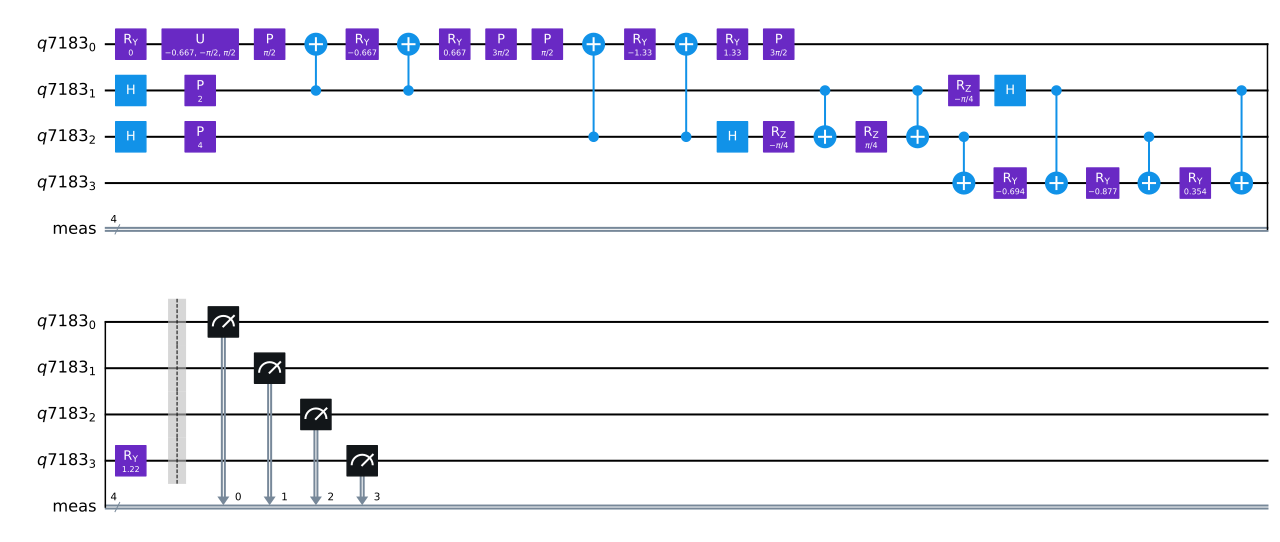

In [18]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialize the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])
    
# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.p(a*t, qrl[0])
qc.p(a*t*2, qrl[1])

qc.u(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw('mpl')

The code below takes as inputs our circuit, the real hardware backend and the set of qubits we want to use, and returns and instance that can be run on the specified device. Creating the circuits with $3$ and $5$ CNOTs is the same but calling the transpile method with the right quantum circuit.

Real hardware devices need to be recalibrated regularly, and the fidelity of a specific qubit or gate can change over time. Furthermore, different chips have different connectivities. If we try to run a circuit that performs a two-qubit gate between two qubits that are not connected on the specified device, the transpiler will add SWAP gates. Therefore it is good practice to check with the IBM Quantum Experience webpage<sup>[[7]](#qexperience)</sup> before running the following code and choose a set of qubits with the right connectivity and lowest error rates at the given time.

In [22]:
from qiskit import ClassicalRegister, IBMQ
from qiskit.compiler import transpile
from qiskit.utils.mitigation import (complete_meas_cal,
                                     CompleteMeasFitter)

from qiskit.providers.fake_provider import FakeYorktown
backend = FakeYorktown()
layout = [2,3,0,4]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

The next step is to create the extra circuits used to mitigate the readout errors<sup>[[3]](#readouterr)</sup>.

In [23]:
meas_cals, state_labels = complete_meas_cal(qubit_list=layout, qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

job = backend.run(qcs, shots=10)

The following plot<sup>[[5]](#tridi)</sup>, shows the results from running the circuit above on real hardware for $10$ different initial states. The $x$-axis represents the angle $\theta$ defining the initial state in each case. The results where obtained after mitigating the readout error and then extrapolating the errors arising during the run of the circuit from the results with the circuits with $1$, $3$ and $5$ CNOTs. 

<img src="images/norm_public.png">

Compare to the results without error mitigation nor extrapolation from the CNOTs<sup>[5](#tridi)</sup>.

<img src="images/noerrmit_public.png">

## 8. Problems<a id='problems'></a>

##### Real hardware:

1. Set the time parameter for the optimised example.

<details>
    <summary> Solution (Click to expand)</summary>
    t = 2.344915690192344

The best result is to set it so that the smallest eigenvalue can be represented exactly, since it's inverse will have the largest contribution in the solution
</details>

2. Create transpiled circuits for $3$ and $5$ CNOTs from a given circuit 'qc'. When creating the circuits you will have to add barriers so that these consecutive CNOT gates do not get cancelled when using the transpile() method.

3. Run your circuits on the real hardware and apply a quadratic fit to the results to obtain the extrapolated value.

## 9. References<a id='references'></a>

1. A. W. Harrow, A. Hassidim, and S. Lloyd, (2009). “Quantum algorithm for linear systems of equations”. Phys. Rev. Lett. 103.15, p. 150502.<a id='hhl'></a>

2. J. R. Shewchuk. (1994). “An Introduction to the Conjugate Gradient Method Without the Agonizing Pain”. Technical Report CMU-CS-94-125, School of Computer Science, Carnegie Mellon University, Pittsburgh, Pennsylvania.<a id='conjgrad'></a> 

3. Wiebe, Nathan & Braun, Daniel & Lloyd, Seth. (2012). “Quantum Algorithm for Data Fitting”. Phys. Rev. Lett. 109. 10.1103/PhysRevLett.109.050505. <a id=‘ml’></a> 

4. Perelshtein, M.R., Pakhomchik, A.I., Melnikov, A.A., Novikov, A.A., Glatz, A., Paraoanu, G.S., Vinokur, V.M. and Lesovik, G.B. (2022). “Solving Large‐Scale Linear Systems of Equations by a Quantum Hybrid Algorithm”. Annalen der Physik, p.2200082. doi:10.1002/andp.202200082. <a id=‘ml’></a> 

5. A. Dewes, F. R. Ong, V. Schmitt, R. Lauro, N. Boulant, P. Bertet, D. Vion, and D. Esteve (2012). “Characterization of a two-transmon processor with individual single-shot qubit readout.” Phys. Rev. Lett. 108, 057002. <a id='readouterr'></a>

6. N. Stamatopoulos, D. J. Egger, Y. Sun, C. Zoufal, R. Iten, N. Shen, and S. Woerner. “Option Pricing using Quantum Computers”. arXiv:1905.02666. <a id='richardson'></a>

7. A. Carrera Vazquez, A. Frisch, D. Steenken, H. S. Barowski, R. Hiptmair, and S. Woerner. “Enhancing Quantum Linear System Algorithm by Richardson Extrapolation,” (to be included).<a id='tridi'></a>

8. R. Iten, O. Reardon-Smith, L. Mondada, E. Redmond, R. Singh Kohli, R. Colbeck. “Introduction to UniversalQCompiler”. arXiv:1904.01072.<a id='qcompiler'></a>

9. https://quantum-computing.ibm.com/.<a id='qexperience'></a>

10. D. Bucher, J. Mueggenburg, G. Kus, I. Haide, S. Deutschle, H. Barowski, D. Steenken, A. Frisch, “Qiskit Aqua: Solving linear systems of equations with the HHL algorithm”. https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/linear_systems_of_equations.ipynb.

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table